## Подключение библиотек, скачивание данных

In [142]:
# %pip install numpy
# %pip install pandas
# %pip install pyvis
# %pip install scipy
# %pip install matplotlib
# %pip install openpyxl
# %pip install arch

In [143]:
import os
import csv
import numpy as np
import pandas as pd
import math
from datetime import datetime

from pyvis.network import Network
import networkx as nx

from numpy import linalg as LA
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.optimize import minimize, fmin_slsqp
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from  matplotlib.pyplot import xticks

import statistics
from scipy.integrate import quad
from scipy.stats import norm

from arch.covariance.kernel import QuadraticSpectral
import time
from tqdm import tqdm

import json
import datetime

import seaborn as sns
sns.set()

In [144]:
## Глобальные переменные
PATH_TO_DATA_OF_STOCKS = #path to data of stock
NUMBER_OF_DAYS_IN_A_MONTH = 30

B = 2  # константа для расчета long-run correlation
PI = 3.1415

portfolio_charectetictics_max = {}
portfolio_charectetictics_min = {}

name_for_portfolio_characteristics_max = 'resulting_portfolio_max.xlsx'
name_for_portfolio_characteristics_min = 'resulting_portfolio_min.xlsx'

name_for_portfolio_stability_max = 'stability_max.xlsx'
name_for_portfolio_stability_min = 'stability_min.xlsx'

In [145]:
# Класс для удобной работы с акциями.
class Stock:
    def __init__(self, ticker_, close_price_, volume_, date_, id_):
        try:
            self.id = id_
            self.ticker = ticker_ 
            self.close_price = close_price_
            self.volume = volume_
            self.risk = None
            self.log_returns = None
            self.date = date_
            self.estimation_windows = None

        except TypeError:
            raise TypeError


In [146]:
## Данная функция приводит данные в необходимый формат
def get_stocks_info(data):
    price, volume, date = [], [], []
    date = list(data['Дата'])
    price = list(data['Цена'].str.replace('.','', regex=True).str.replace(',','.',regex=True).astype(float))
    volume = list(data['Объём'].str.replace(',','.',regex=True))
    return price, volume, date


In [147]:
## Функция для загрузки данных об активах. Деление на обучающий период и наблюдаемый.
def load_data(date_start, date_end):
    TICKERS = []
    DATA_OF_STOCKS_FOR_BUILDING_MODEL = []
    DATA_OF_STOCKS_FOR_EVALUATION = []

    directory = PATH_TO_DATA_OF_STOCKS
    count = 0 
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            price, volume, date = [], [], []

            data = pd.read_csv(f)
            data['Дата'] = pd.to_datetime(data['Дата'], format="%d.%m.%Y")
            info_for_exp = data.loc[data['Дата'] >= date_start ] #01-01-2017
            info_for_exp = info_for_exp.loc[info_for_exp['Дата'] <= date_end] #01-01-2019
            info_for_per = data.loc[data['Дата'] > date_end] #01-01-2019
            
            price, volume, date = get_stocks_info(info_for_exp)
            price = price[::-1]
            volume = volume[::-1]
            date = date[::-1]

            DATA_OF_STOCKS_FOR_BUILDING_MODEL.append(Stock(filename[:-4], price, volume, date, count))


            price, volume, date = get_stocks_info(info_for_per)
            price = price[::-1]
            volume = volume[::-1]
            date = date[::-1]

            DATA_OF_STOCKS_FOR_EVALUATION.append(Stock(filename[:-4], price, volume, date, count))
            count += 1
            
    for stock in DATA_OF_STOCKS_FOR_BUILDING_MODEL:
            TICKERS.append(stock.ticker)

    return DATA_OF_STOCKS_FOR_BUILDING_MODEL, DATA_OF_STOCKS_FOR_EVALUATION, TICKERS

## Обработка данных

In [148]:
## получение преобразование цен актива в логарифмическую доходность
def get_log_returns(Stocks, train_stocks = None):
    if train_stocks is None:
        for stock in Stocks:
            close_prices = pd.Series(stock.close_price.copy())
            stock.log_returns = close_prices.pct_change()
    else:
        for stock in Stocks:
            close_prices = pd.Series(stock.close_price.copy())
            stock.log_returns = close_prices.pct_change()
            stock.log_returns[0] = np.log(stock.close_price[0]/train_stocks[stock.id].close_price[-1])

## приводит количество наблюдений к одинаковому значению для всех рассматриваемых активов
def same_length_of_returns(Stocks):
    mimimum = 9999999

    for stock in Stocks:
        if len(stock.log_returns) < mimimum:
            mimimum = len(stock.log_returns)

    for stock in Stocks:
        stock.log_returns = stock.log_returns[:mimimum - 1] 
        stock.date = stock.date[:mimimum - 1] 

In [149]:
## Препроцессинг данных
def data_processing(DATA_OF_STOCKS_FOR_BUILDING_MODEL, DATA_OF_STOCKS_FOR_EVALUATION):
    
    get_log_returns(DATA_OF_STOCKS_FOR_BUILDING_MODEL, train_stocks = None)
    get_log_returns(DATA_OF_STOCKS_FOR_EVALUATION, train_stocks = DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    
    same_length_of_returns(DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    same_length_of_returns(DATA_OF_STOCKS_FOR_EVALUATION)
    
    for stock in DATA_OF_STOCKS_FOR_BUILDING_MODEL:
        estsim = []
        weekend_return = stock.log_returns[1:]
        for i in np.arange(len(weekend_return)):
            if len(weekend_return.iloc[i: i + NUMBER_OF_DAYS_IN_A_MONTH]) >= NUMBER_OF_DAYS_IN_A_MONTH:
                tem = weekend_return.iloc[i: i + NUMBER_OF_DAYS_IN_A_MONTH]
                estsim.append(np.average(tem))
        stock.estimation_windows = estsim


## Оценка матрицы ковариации (long-run correlation)

In [150]:
def get_long_run_correlation(DATA_OF_STOCKS_FOR_BUILDING_MODEL):
    long_run_correlation = []
    res = 0
    for i in tqdm(np.arange(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL))):
        w_estimations_i = np.array([DATA_OF_STOCKS_FOR_BUILDING_MODEL[i].estimation_windows])
        cor = []
        for j in np.arange(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL)):
            w_estimations_j = np.array([DATA_OF_STOCKS_FOR_BUILDING_MODEL[j].estimation_windows])
            matrix_result = QuadraticSpectral(np.array(np.concatenate((w_estimations_i.T, w_estimations_j.T), axis=1)), bandwidth=B)
            matrix_result = matrix_result.cov.long_run
            res = matrix_result[0][1]/(np.sqrt(matrix_result[0][0]*matrix_result[1][1]))
            cor.append(res) 
        long_run_correlation.append(cor)
    return long_run_correlation

## Построение графов

In [151]:
def get_distance(p):
    under_sqrt = 2*(1-p)
    return np.sqrt(under_sqrt)

In [152]:
## Матрица смежности полного графа
def get_Adjancency_matrix(long_run_correlation):
    Adjacency_matrix = []
    for i in np.arange(len(long_run_correlation)):
        row = []
        for j in np.arange(len(long_run_correlation)):
            if i == j:
                distance = 0
            else:
                distance = get_distance(long_run_correlation[i][j])
            row.append(distance)
        Adjacency_matrix.append(row)
    return Adjacency_matrix

In [153]:
## визуализация данных
def draw_graph(graph, name_graph):
    Net = Network(height='1300px',
                  width='100%',
                  bgcolor='#222222',
                  font_color='white',
                  notebook=True,
                 cdn_resources = 'remote')
    
    for i in graph.nodes:
        for j in graph.nodes:
            if i != j:
                try:
                    Net.add_node(list(graph.nodes[i].values())[0], list(graph.nodes[i].values())[0], title = list(graph.nodes[i].values())[0] )
                    Net.add_node(list(graph.nodes[j].values())[0], list(graph.nodes[j].values())[0], title=list(graph.nodes[j].values())[0])
                    Net.add_edge(list(graph.nodes[i].values())[0], list(graph.nodes[j].values())[0], title=list(graph.get_edge_data(i, j).values())[0])
                except: continue
    
    Net.toggle_physics(True)
    Net.show(name_graph)


In [154]:
## Построение полного графа и его подграфов
def build_graphs(long_run_correlation, Stocks):
    Adjacency_matrix = get_Adjancency_matrix(long_run_correlation)

    ## Полный граф
    COMPLETE_GRAPH = nx.Graph()
    for i in np.arange(len(Adjacency_matrix)):
        for j in np.arange(len(Adjacency_matrix)):
            if i != j:
                COMPLETE_GRAPH.add_node(Stocks[i].ticker, label = Stocks[i].ticker )
                COMPLETE_GRAPH.add_node(Stocks[j].ticker, label=Stocks[j].ticker)
                COMPLETE_GRAPH.add_edge(Stocks[i].ticker, Stocks[j].ticker, weight=Adjacency_matrix[i][j])

    draw_graph(COMPLETE_GRAPH, 'completed_graph.html')

    ## Минимальное оставное дерево
    Tcsr = minimum_spanning_tree(Adjacency_matrix)
    mat = Tcsr.toarray()
    MST = nx.Graph()
    for i in np.arange(len(mat)):
        for j in np.arange(len(mat)):
            if i != j:
                if mat[i][j] != 0:
                    MST.add_node(Stocks[i].ticker, label = Stocks[i].ticker )
                    MST.add_node(Stocks[j].ticker, label = Stocks[j].ticker)
                    MST.add_edge(Stocks[i].ticker, Stocks[j].ticker, weight=mat[i][j])

    draw_graph(MST, 'Minimun_spaning_tree.html')

    ## Планнарный график
    edges = {}
    for i in range(len(Adjacency_matrix)):
        for j in range(len(Adjacency_matrix)):
            edges[(i,j)] = Adjacency_matrix[i][j]


    nb_nodes = len(Stocks)
    PMFG = nx.Graph()
    sorted_edges = dict(sorted(edges.items(), key=lambda x: x[1], reverse=True))
    for i, edge in enumerate(sorted_edges):
        PMFG.add_node(list(sorted_edges.keys())[i][0], label = Stocks[list(sorted_edges.keys())[i][0]].ticker)
        PMFG.add_node(list(sorted_edges.keys())[i][1], label = Stocks[list(sorted_edges.keys())[i][1]].ticker)
        PMFG.add_edge(list(sorted_edges.keys())[i][0], list(sorted_edges.keys())[i][1], weight = list(sorted_edges.values())[i])
        if nx.check_planarity(PMFG)[0]:
            continue
        else:
            PMFG.remove_edge(list(sorted_edges.keys())[i][0], list(sorted_edges.keys())[i][1])
        ne = PMFG.number_of_edges()
        if ne == 3*(nb_nodes-2):
            break

    draw_graph(PMFG, 'Planar_max_filter.html')
    
    ## График значимости порога
    THRESHOLD_FOR_EDGES_IN_GRAPH_1 = round(np.mean(long_run_correlation),3)
    
    for i in np.arange(len(long_run_correlation)):
        for j in np.arange(len(long_run_correlation)):
            if long_run_correlation[i][j] <= THRESHOLD_FOR_EDGES_IN_GRAPH_1:
                long_run_correlation[i][j] = 0 

    Adjacency_matrix = get_Adjancency_matrix(long_run_correlation)

    THRESHOLD_FOR_EDGES_IN_GRAPH_2 = round(np.mean(Adjacency_matrix),3)

    THRESHOLD = nx.Graph()
    for i in np.arange(len(Adjacency_matrix)):
        for j in np.arange(len(Adjacency_matrix)):
            if i != j:
                if Adjacency_matrix[i][j] != 0:
                    if  Adjacency_matrix[i][j] <= THRESHOLD_FOR_EDGES_IN_GRAPH_2:
                        THRESHOLD.add_node(Stocks[i].ticker, label = Stocks[i].ticker )
                        THRESHOLD.add_node(Stocks[j].ticker, label = Stocks[j].ticker)
                        THRESHOLD.add_edge(Stocks[i].ticker, Stocks[j].ticker, weight=Adjacency_matrix[i][j])

    draw_graph(THRESHOLD, 'Threshold_significance_graph.html')

    return COMPLETE_GRAPH, MST, PMFG, THRESHOLD


## Centrality measures

### Betweenness

In [155]:
def get_betweenness(COMPLETE_GRAPH, MST,THRESHOLD,PMFG, Stocks ):
    complete_graph_betweenness = dict(nx.betweenness_centrality(COMPLETE_GRAPH).items())
    mst_betweenness = dict(nx.betweenness_centrality(MST).items())
    treshold_betweenness = dict(nx.betweenness_centrality(THRESHOLD).items())

    pmfg_betweenness = {}
    for val in list(nx.betweenness_centrality(PMFG).items()):
        pmfg_betweenness[Stocks[val[0]].ticker] = val[1]

    return complete_graph_betweenness, mst_betweenness, treshold_betweenness, pmfg_betweenness

### Eigenvalue centrality

In [156]:
def get_eigenvalue_centrality(COMPLETE_GRAPH, MST, THRESHOLD, PMFG, Stocks ):
    complete_graph_eigenvalue_centrality = dict(nx.eigenvector_centrality(COMPLETE_GRAPH).items())
    mst_eigenvalue_centrality = dict(nx.eigenvector_centrality(MST, 10000).items())
    treshold_eigenvalue_centrality = dict(nx.eigenvector_centrality(THRESHOLD).items())

    pmfg_eigenvalue_centrality = {}
    for val in list(nx.eigenvector_centrality(PMFG, 1000).items()):
        pmfg_eigenvalue_centrality[Stocks[val[0]].ticker] = val[1]
    
    return complete_graph_eigenvalue_centrality, mst_eigenvalue_centrality, treshold_eigenvalue_centrality, pmfg_eigenvalue_centrality


### Expected force


In [157]:
## от i вершины до 1 любой на расстоянии 1
def one_vertices_distance_one(v, matrix):
    res = []
    for i in np.arange(len(matrix[v])):
        count = 0
        if matrix[v][i] == 1:
            # print(v, i)
            for l in np.arange(len(matrix[i])):
                if l != v and matrix[i][l] == 1:
                    # print('1 loop ', i, l)
                    count += 1

            for k in np.arange(len(matrix[v])):
                if k != i and matrix[v][k] == 1:
                    # print('2 loop ', v, k)
                    count += 1
                    
            res.append(count)
    return res

In [158]:
def two_vertices_distance_one(v, matrix):
    visited = []
    res = []
    if (sum(matrix[v]) >= 2):
        for i in np.arange(len(matrix[v])):
            if matrix[v][i] != 0:
                for j in np.arange(i + 1, len(matrix[v])):
                    count = 0
                    if j != v and matrix[v][j] == 1 and ((i , j) not in visited) and ((j , i) not in visited):
                        # print(v,i,j)
                        visited.append((i , j))
                        
                        for k in np.arange(len(matrix[i])):
                            if matrix[i][k] == 1 and k != v and k != j:
                                # print('first loop ', i,k)
                                count +=1

                        for l in np.arange(len(matrix[j])):
                            if matrix[j][l] == 1 and l != v and l != i:
                                # print('second loop ', j,l)
                                count += 1
                                
                        for o in np.arange(len(matrix[v])):
                            if matrix[v][o] == 1 and o != v and o != j and o != i:
                                # print('third loop ', v,o)
                                count +=1
                        if count == 0:
                            res.append(-1)
                        else:
                            res.append(count)        
    else:
        res.append(-1)

    return res

In [159]:
def one_vertices_distance_two(v, matrix):
    res = []
    for i in np.arange(len(matrix[v])):
        if matrix[v][i] == 1:
            for k in np.arange(len(matrix[i])):
                count = 0
                if k != v and matrix[i][k] == 1:
                    # print('path',v,i,k )
                    
                    for m in np.arange(len(matrix[i])):
                        if m != v and m != k and matrix[i][m] == 1:
                            # print('first loop ',i, m )
                            count += 1

                    for l in  np.arange(len(matrix[k])):
                        if l != v and l != i and matrix[k][l] == 1:
                            # print('second loop ', k,l)
                            count += 1
                    
                   
                    for o in np.arange(len(matrix[v])):
                        if o != v and o != i and o != k and matrix[v][o] == 1 :
                            # print('third loop ', v,o)
                            count += 1
                   
                    res.append(count)
    return res

                    

In [160]:
def get_esstimate_b(start_v, number_cluster,  res):
    if sum(res[start_v]) == 0:
        return 0 
    else:
        return res[start_v][number_cluster]/sum(res[start_v])

In [161]:
def get_expected_force(matrix):
    d_1_case = []
    d_2_case = []
    d_3_case = []
    for v in np.arange(len(matrix)):
        d_1_case.append(one_vertices_distance_one(v, matrix))
        d_2_case.append(two_vertices_distance_one(v, matrix))
        d_3_case.append(one_vertices_distance_two(v, matrix))
    # print(d_1_case)
    # print(d_2_case)
    # print(d_3_case)
    res = []
    for start_v in np.arange(len(matrix)):
        if d_2_case[start_v][0] != -1:
            res.append(d_1_case[start_v] + d_2_case[start_v] + d_3_case[start_v])
        else:
            res.append(d_1_case[start_v] + d_3_case[start_v])
    # print('res', res)

    es =[]
    for p in np.arange(len(res)):
        s = 0 
        for j in np.arange(len(res[p])):
            d = get_esstimate_b(p, j,  res)
            if d != 0:
                s += d * math.log(d)
        if s == 0:
            es.append(s)
        else:
            es.append(-s)

    return es

In [162]:
def get_Adj_matrix(graph, Stocks):
    Adj_matrix = []

    for i in np.arange(len(Stocks)):
        row = []
        for j in np.arange(len(Stocks)):
            if (Stocks[i].ticker, Stocks[j].ticker) in graph.edges():
                row.append(1)
            else:
                row.append(0)
        Adj_matrix.append(row)
    return Adj_matrix


def get_Adj_matrix_for_planar(graph, Stocks):
    Adj_matrix = []

    for i in np.arange(len(Stocks)):
        row = []
        for j in np.arange(len(Stocks)):
            if (Stocks[i].id, Stocks[j].id) in graph.edges():
                row.append(1)
            else:
                row.append(0)
        Adj_matrix.append(row)
    return Adj_matrix


In [163]:
def get_expected_force_total(COMPLETE_GRAPH, MST, THRESHOLD, PMFG, Stocks):
    complete_graph_expected_force = get_expected_force(get_Adj_matrix(COMPLETE_GRAPH, Stocks))
    mst_eigenvalue_expected_force = get_expected_force(get_Adj_matrix(MST, Stocks))
    treshold_expected_force = get_expected_force(get_Adj_matrix(THRESHOLD, Stocks))
    pmfg_expected_force = get_expected_force(get_Adj_matrix_for_planar(PMFG, Stocks))

    return complete_graph_expected_force, mst_eigenvalue_expected_force, treshold_expected_force, pmfg_expected_force

In [164]:
## Функция подсчитывает меры цетральности для каждого графа
def get_centrality_measures(COMPLETE_GRAPH, MST, PMFG, THRESHOLD, Stocks, TICKERS):

    ## BETWEENNESS
    complete_graph_betweenness,\
    mst_betweenness,\
    treshold_betweenness,\
    pmfg_betweenness = get_betweenness(COMPLETE_GRAPH, MST,THRESHOLD,PMFG, Stocks)
    BETWEENNESS = pd.DataFrame({'Complete graph': complete_graph_betweenness, 
                           'Minimum spanning tree': mst_betweenness,
                           'Threshold significance graph' : treshold_betweenness,
                           'Planar max filter graph': pmfg_betweenness })
    
    ## EIGENVALUE_CENTRALITY
    complete_graph_eigenvalue_centrality,\
    mst_eigenvalue_centrality,\
    treshold_eigenvalue_centrality, \
    pmfg_eigenvalue_centrality = get_eigenvalue_centrality(COMPLETE_GRAPH, MST, THRESHOLD, PMFG, Stocks)
    EIGENVALUE_CENTRALITY = pd.DataFrame({'Complete graph': complete_graph_eigenvalue_centrality, 
                           'Minimum spanning tree': mst_eigenvalue_centrality,
                           'Threshold significance graph' : treshold_eigenvalue_centrality,
                           'Planar max filter graph': pmfg_eigenvalue_centrality })
    

    ## EXPECTED_FORCE
    complete_graph_expected_force,\
    mst_eigenvalue_expected_force,\
    treshold_expected_force,\
    pmfg_expected_force = get_expected_force_total(COMPLETE_GRAPH, MST, THRESHOLD, PMFG, Stocks)

    EXPECTED_FORCE = pd.DataFrame({'Complete graph': complete_graph_expected_force, 
                           'Minimum spanning tree': mst_eigenvalue_expected_force,
                           'Threshold significance graph' : treshold_expected_force,
                           'Planar max filter graph': pmfg_expected_force}, index=TICKERS)
    
    return BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE
    

## Стратегии

In [165]:
def get_return_mean_cov(stocks):
    # получить по выбранным активам матрицу их доходностей,
    # вектор средних доходностей и матрицу ковариации
    r_matrix = {}
    for stock in stocks:
        r_matrix[stock.ticker] = stock.log_returns[1:].copy()
    r_df = pd.DataFrame(r_matrix)
    return r_df.values, r_df.mean().values, r_df.cov().values

### Return maximization strategies

In [166]:
def objective_function_max(X, mean_vec):
    return -1*(X.dot(np.transpose(np.array([mean_vec]))))#

In [167]:
def con(X, i, j):
    return X[j] - X[i]

In [168]:
def constraint3(centrality_measures):
    constraints = []
    for i in range(len(centrality_measures)):
        for j in range(len(centrality_measures)):
            if i != j:
                    if round(centrality_measures[i],9) >= round(centrality_measures[j],9):
                        constraints.append({'type': 'ineq', 'fun':con, 'args':(i,j,) })
    return constraints

In [169]:
def return_maximization_strategies(objective_function, mean_returns, cov_matrix, N, bound, measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value = None, stocks = None):
        X = np.ones(N)
        X = X / X.sum()
        bounds = bound
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - bounds[0][1]},
                       {'type': 'ineq', 'fun': lambda x: np.trace(cov_matrix)/N - x.transpose().dot(cov_matrix).dot(x)}]
        if centrality_measure:
               if null_value is not None:
                    X = null_value
               constraints = constraints + constraint3(measure_of_centrality[type_graph])

        minimized = minimize(objective_function,
                         X,
                         args=(mean_returns),
                         method='SLSQP',
                         constraints=constraints,
                         bounds=bounds, options = {'maxiter': 10000} ).x
        return minimized

### Risk minimization strategies

In [170]:
def objective_function_min(X, cov_matrix):
    return np.transpose(X).dot(cov_matrix).dot(X)

In [171]:
def return_minimization_strategies(objective_function, mean_returns, cov_matrix, N, bound, measure_of_centrality = None, type_graph = None, centrality_measure = False,  null_value = None, stocks = None):
        X = np.ones(N)
        bounds = bound
        E_matrix = [1]*N

        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - bounds[0][1]},
                       {'type': 'ineq', 'fun': lambda x: np.transpose(x).dot(mean_returns) - (np.transpose(np.array(E_matrix)).dot(mean_returns))/N}]

        if centrality_measure:
                if null_value is not None:
                    X = null_value
                constraints = constraints + constraint3(measure_of_centrality[type_graph])

        minimized = minimize(objective_function,
                         X,
                         args=(cov_matrix),
                         method='SLSQP',
                         constraints=constraints,
                         bounds=bounds, options = {'maxiter': 10000}).x
        return minimized
        

## Эксперементы основанные на максимизации доходностей

#### Individual strategies (Альтернативные стратегии)

In [172]:
def MAX_Individual_strategies(DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE, resulting_portfolio_max):
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    #Benchmark
    benchmark_max_weights = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value= None, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    resulting_portfolio_max['Benchmark'] = benchmark_max_weights

    ## Betweenness
    weights_max_minimun_spaning_tree_with_betweenness = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Minimum spanning tree', centrality_measure = True, null_value = benchmark_max_weights ,stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_weights_max_planar_max_filter_with_betweenness = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Planar max filter graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL )
    weights_max_threshold_significance_graph_with_betweenness = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Threshold significance graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL )

    resulting_portfolio_max['Betweenness_MST'] = weights_max_minimun_spaning_tree_with_betweenness
    resulting_portfolio_max['Betweenness_PMFG'] = weights_max_weights_max_planar_max_filter_with_betweenness
    resulting_portfolio_max['Betweenness_Threshold'] = weights_max_threshold_significance_graph_with_betweenness

    ## Eigenvalue centrality
    weights_max_completed_graph_with_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Complete graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_minimun_spaning_tree_with_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Minimum spanning tree', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_weights_max_planar_max_filter_with_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Planar max filter graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_threshold_significance_graph_with_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Threshold significance graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)

    resulting_portfolio_max['Eigenvalue_Complete'] = weights_max_completed_graph_with_eigenvalue_centrality
    resulting_portfolio_max['Eigenvalue_MST'] = weights_max_minimun_spaning_tree_with_eigenvalue_centrality
    resulting_portfolio_max['Eigenvalue_PMFG'] = weights_max_weights_max_planar_max_filter_with_eigenvalue_centrality
    resulting_portfolio_max['Eigenvalue_Threshold'] = weights_max_threshold_significance_graph_with_eigenvalue_centrality

    ## Expected force
    weights_max_completed_graph_with_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Complete graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_minimun_spaning_tree_with_expected_force  = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Minimum spanning tree', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_weights_max_planar_max_filter_with_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Planar max filter graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_max_threshold_significance_graph_with_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Threshold significance graph', centrality_measure = True, null_value = benchmark_max_weights, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)

    resulting_portfolio_max['Expected_force_Complete'] = weights_max_completed_graph_with_expected_force
    resulting_portfolio_max['Expected_force_MST'] = weights_max_minimun_spaning_tree_with_expected_force
    resulting_portfolio_max['Expected_force_PMFG'] = weights_max_weights_max_planar_max_filter_with_expected_force
    resulting_portfolio_max['Expected_force_Threshold'] = weights_max_threshold_significance_graph_with_expected_force

    return resulting_portfolio_max
    

#### Combination strategies

In [173]:
def get_new_centrality_measure(graph_name, list_of_stocks, centrality_measure_):
    centrality_measure = []
    names_stocks = []
    for stock in list_of_stocks:
        if stock.ticker in centrality_measure_.index:
            centrality_measure.append(centrality_measure_[graph_name][stock.ticker])
            names_stocks.append(stock.ticker)

    return pd.DataFrame(centrality_measure, columns=[graph_name], index = list(names_stocks))

In [174]:
def MAX_get_combination_strategies(resulting_portfolio_max, DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE):    
    stocks_for_benchmark = DATA_OF_STOCKS_FOR_BUILDING_MODEL[:int(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL)/2 + 1)]
    stocks_for_centrality_measures = [i for i in DATA_OF_STOCKS_FOR_BUILDING_MODEL if i not in stocks_for_benchmark]
    index_1 = int(len(stocks_for_centrality_measures)/4)
    index_2 = int(2 * len(stocks_for_centrality_measures)/4)
    index_3 = int(3 * len(stocks_for_centrality_measures)/4)
    index_4 = int(4 * len(stocks_for_centrality_measures)/4)
    stocks_for_completed_graph = stocks_for_centrality_measures[:index_1]
    stocks_for_minimun_spaning_tree = stocks_for_centrality_measures[index_1:index_2]
    stocks_threshold_significance_graph = stocks_for_centrality_measures[index_2 : index_3]
    stocks_for_planar_max_filter = stocks_for_centrality_measures[index_3:index_4]


    ## Betweennes + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value = None, stocks = stocks_for_benchmark )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_betweenness = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, BETWEENNESS)
    weights_completed_grapg = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_betweenness, 'Complete graph', centrality_measure = True,  null_value = None, stocks = stocks_for_completed_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_betweenness = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, BETWEENNESS)
    weights_minimun_spaning_tree  = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_betweenness, 'Minimum spanning tree', centrality_measure = True,  null_value = None, stocks = stocks_for_minimun_spaning_tree )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_betweenness = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, BETWEENNESS)
    weights_threshold_significance_graph = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_betweenness, 'Threshold significance graph', centrality_measure = True,  null_value = None, stocks = stocks_threshold_significance_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_betweenness = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, BETWEENNESS)
    weights_planar_max_filter =  return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_betweenness, 'Planar max filter graph', centrality_measure = True,  null_value = None, stocks = stocks_for_planar_max_filter)

    res_betweenness_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_betweenness_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_betweenness_max.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_betweenness_max.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_betweenness_max.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_betweenness_max.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_max['Betweenness + B'] = np.array([list(w.values())[0] for w in res_betweenness_max])



    ## Eigenvalue centrality + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value = None, stocks = stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_eigenvalue_centrality = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, EIGENVALUE_CENTRALITY)
    weights_completed_grapg = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_eigenvalue_centrality, 'Complete graph', centrality_measure = True,  null_value = None, stocks = stocks_for_completed_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_eigenvalue_centrality = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, EIGENVALUE_CENTRALITY)
    weights_minimun_spaning_tree  = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_eigenvalue_centrality, 'Minimum spanning tree', centrality_measure = True, null_value = None, stocks = stocks_for_minimun_spaning_tree )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_eigenvalue_centrality = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, EIGENVALUE_CENTRALITY)
    weights_threshold_significance_graph = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_eigenvalue_centrality, 'Threshold significance graph', centrality_measure = True, null_value = None, stocks = stocks_threshold_significance_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_eigenvalue_centrality = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, EIGENVALUE_CENTRALITY)
    weights_planar_max_filter =  return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_eigenvalue_centrality, 'Planar max filter graph', centrality_measure = True, null_value=None,  stocks = stocks_for_planar_max_filter )

    res_eigenvalue_centrality_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_eigenvalue_centrality_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_eigenvalue_centrality_max.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_eigenvalue_centrality_max.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_eigenvalue_centrality_max.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_eigenvalue_centrality_max.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_max['Eigenvalue + B'] = np.array([list(w.values())[0] for w in res_eigenvalue_centrality_max])



    ## Expected force + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value= None, stocks= stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_expected_force = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, EXPECTED_FORCE)
    weights_completed_grapg = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_expected_force, 'Complete graph', centrality_measure = True, null_value = None, stocks = stocks_for_completed_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_expected_force = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, EXPECTED_FORCE)
    weights_minimun_spaning_tree  = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_expected_force, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks = stocks_for_minimun_spaning_tree)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_expected_force = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, EXPECTED_FORCE)
    weights_threshold_significance_graph = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_expected_force, 'Threshold significance graph', centrality_measure = True, null_value= None, stocks = stocks_threshold_significance_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_expected_force = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, EXPECTED_FORCE)
    weights_planar_max_filter =  return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_expected_force, 'Planar max filter graph', centrality_measure = True,null_value=None,  stocks = stocks_for_planar_max_filter )

    res_expected_force_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_expected_force_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_expected_force_max.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_expected_force_max.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_expected_force_max.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_expected_force_max.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_max['Expected force + B'] = np.array([list(w.values())[0] for w in res_expected_force_max])



    stocks_for_benchmark = DATA_OF_STOCKS_FOR_BUILDING_MODEL[:int(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL)/2)]
    stocks_for_centrality_measures = [i for i in DATA_OF_STOCKS_FOR_BUILDING_MODEL if i not in stocks_for_benchmark]
    index_1 = int(len(stocks_for_centrality_measures)/3)
    index_2 = int(2 * len(stocks_for_centrality_measures)/3)
    index_3 = int(3 * len(stocks_for_centrality_measures)/3)
    stocks_for_betweenness = stocks_for_centrality_measures[:index_1]
    stocks_for_eigenvalue_centrality  = stocks_for_centrality_measures[index_1:index_2]
    stocks_for_expected_force = stocks_for_centrality_measures[index_2:index_3]


    ## MST + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value= None, stocks = stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Minimum spanning tree', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Minimum spanning tree', centrality_measure = True, null_value= None, stocks = stocks_for_betweenness )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Minimum spanning tree', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks = stocks_for_eigenvalue_centrality )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Minimum spanning tree', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Minimum spanning tree', centrality_measure = True, null_value= None, stocks= stocks_for_expected_force  )


    res_MST_B_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_MST_B_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_MST_B_max.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_MST_B_max.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_MST_B_max.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 


    resulting_portfolio_max['MST + B'] = np.array([list(w.values())[0] for w in res_MST_B_max])



    ## PMFG + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Planar max filter graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks = stocks_for_betweenness)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Planar max filter graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks = stocks_for_eigenvalue_centrality )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Planar max filter graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Planar max filter graph', centrality_measure = True, null_value= None, stocks=stocks_for_expected_force  )


    res_PMFG_B_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_PMFG_B_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_PMFG_B_max.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_PMFG_B_max.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_PMFG_B_max.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_max['PMFG + B'] = np.array([list(w.values())[0] for w in res_PMFG_B_max])



    ## Treshold + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks = stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Threshold significance graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks = stocks_for_betweenness)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Threshold significance graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks = stocks_for_eigenvalue_centrality )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Threshold significance graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks = stocks_for_expected_force  )



    res_Treshold_B_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_Treshold_B_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_Treshold_B_max.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_Treshold_B_max.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_Treshold_B_max.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 


    resulting_portfolio_max['Threshold + B'] = np.array([list(w.values())[0] for w in res_Treshold_B_max])



    ## Complete graph + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_max_benchmark = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks= stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Complete graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Complete graph', centrality_measure = True, null_value=None, stocks = stocks_for_betweenness)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Complete graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Complete graph', centrality_measure = True, null_value=None,  stocks= stocks_for_eigenvalue_centrality  )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Complete graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_maximization_strategies(objective_function_max, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Complete graph', centrality_measure = True, null_value=None, stocks = stocks_for_expected_force )


    res_completed_B_max = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_completed_B_max.append({list(stocks_for_benchmark)[stock].ticker: weights_max_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_completed_B_max.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_completed_B_max.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_completed_B_max.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_max['Complete + B'] = np.array([list(w.values())[0] for w in res_completed_B_max])


    for port in resulting_portfolio_max:
        resulting_portfolio_max[port] = np.round(resulting_portfolio_max[port], decimals=3)


    return resulting_portfolio_max

## Эксперементы основанные на минимизации риска

In [175]:
def MIN_Individual_strategies(DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE, resulting_portfolio_min):
    #Benchmark
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    benchmark_min_weights = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value= None, stocks=DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    resulting_portfolio_min['Benchmark'] = benchmark_min_weights

    ## Betweenness
    weights_min_minimun_spaning_tree_with_betweenness = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Minimum spanning tree', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL )
    weights_min_weights_max_planar_max_filter_with_betweenness = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Planar max filter graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL )
    weights_min_threshold_significance_graph_with_betweenness = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), BETWEENNESS, 'Threshold significance graph', centrality_measure = True,  null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL )
    resulting_portfolio_min['Betweenness_MST'] = weights_min_minimun_spaning_tree_with_betweenness
    resulting_portfolio_min['Betweenness_PMFG'] = weights_min_weights_max_planar_max_filter_with_betweenness
    resulting_portfolio_min['Betweenness_Threshold'] = weights_min_threshold_significance_graph_with_betweenness

    ## Eigenvalue centrality
    weights_min_completed_graph_with_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Complete graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_minimun_spaning_tree_with_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Minimum spanning tree', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_weights_max_planar_max_filter_with_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Planar max filter graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_threshold_significance_graph_with_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EIGENVALUE_CENTRALITY, 'Threshold significance graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    resulting_portfolio_min['Eigenvalue_Complete'] = weights_min_completed_graph_with_eigenvalue_centrality
    resulting_portfolio_min['Eigenvalue_MST'] = weights_min_minimun_spaning_tree_with_eigenvalue_centrality
    resulting_portfolio_min['Eigenvalue_PMFG'] = weights_min_weights_max_planar_max_filter_with_eigenvalue_centrality
    resulting_portfolio_min['Eigenvalue_Threshold'] = weights_min_threshold_significance_graph_with_eigenvalue_centrality
    
    ## Expected force
    weights_min_completed_graph_with_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Complete graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_minimun_spaning_tree_with_expected_force  = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Minimum spanning tree', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_weights_max_planar_max_filter_with_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Planar max filter graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    weights_min_threshold_significance_graph_with_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(DATA_OF_STOCKS_FOR_BUILDING_MODEL), ((0,1),), EXPECTED_FORCE, 'Threshold significance graph', centrality_measure = True, null_value= benchmark_min_weights, stocks= DATA_OF_STOCKS_FOR_BUILDING_MODEL)

    resulting_portfolio_min['Expected_force_Complete'] = weights_min_completed_graph_with_expected_force
    resulting_portfolio_min['Expected_force_MST'] = weights_min_minimun_spaning_tree_with_expected_force
    resulting_portfolio_min['Expected_force_PMFG'] = weights_min_weights_max_planar_max_filter_with_expected_force
    resulting_portfolio_min['Expected_force_Threshold'] = weights_min_threshold_significance_graph_with_expected_force
    
    return resulting_portfolio_min
    


#### Combination strategies

In [176]:
def MIN_get_combination_strategies(resulting_portfolio_min, DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE):    
    stocks_for_benchmark = DATA_OF_STOCKS_FOR_BUILDING_MODEL[:int(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL)/2 + 1)]
    stocks_for_centrality_measures = [i for i in DATA_OF_STOCKS_FOR_BUILDING_MODEL if i not in stocks_for_benchmark]
    index_1 = int(len(stocks_for_centrality_measures)/4)
    index_2 = int(2 * len(stocks_for_centrality_measures)/4)
    index_3 = int(3 * len(stocks_for_centrality_measures)/4 )
    index_4 = int(4 * len(stocks_for_centrality_measures)/4)
    stocks_for_completed_graph = stocks_for_centrality_measures[:index_1]
    stocks_for_minimun_spaning_tree = stocks_for_centrality_measures[index_1:index_2]
    stocks_threshold_significance_graph = stocks_for_centrality_measures[index_2 : index_3]
    stocks_for_planar_max_filter = stocks_for_centrality_measures[index_3:index_4]

    ## Betweennes + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value= None, stocks = stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_betweenness = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, BETWEENNESS)
    weights_completed_grapg = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_betweenness, 'Complete graph', centrality_measure = True, null_value=None, stocks= stocks_for_completed_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_betweenness = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, BETWEENNESS)
    weights_minimun_spaning_tree  = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_betweenness, 'Minimum spanning tree', centrality_measure = True, null_value= None, stocks = stocks_for_minimun_spaning_tree )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_betweenness = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, BETWEENNESS)
    weights_threshold_significance_graph = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_betweenness, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks = stocks_threshold_significance_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_betweenness = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, BETWEENNESS)
    weights_planar_max_filter =  return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_betweenness, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks = stocks_for_planar_max_filter )

    res_betweenness_min = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_betweenness_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_betweenness_min.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_betweenness_min.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_betweenness_min.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_betweenness_min.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_min['Betweenness + B'] = np.array([list(w.values())[0] for w in res_betweenness_min])



    ## Eigenvalue centrality + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_eigenvalue_centrality = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, EIGENVALUE_CENTRALITY)
    weights_completed_grapg = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_eigenvalue_centrality, 'Complete graph', centrality_measure = True, null_value=None, stocks=stocks_for_completed_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_eigenvalue_centrality = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, EIGENVALUE_CENTRALITY)
    weights_minimun_spaning_tree  = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_eigenvalue_centrality, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks = stocks_for_minimun_spaning_tree)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_eigenvalue_centrality = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, EIGENVALUE_CENTRALITY)
    weights_threshold_significance_graph = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_eigenvalue_centrality, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks= stocks_threshold_significance_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_eigenvalue_centrality = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, EIGENVALUE_CENTRALITY)
    weights_planar_max_filter =  return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_eigenvalue_centrality, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks=stocks_for_planar_max_filter)

    res_eigenvalue_centrality_min = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_eigenvalue_centrality_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_eigenvalue_centrality_min.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_eigenvalue_centrality_min.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_eigenvalue_centrality_min.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_eigenvalue_centrality_min.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_min['Eigenvalue + B'] = np.array([list(w.values())[0] for w in res_eigenvalue_centrality_min])



    ## Expected force + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks = stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_completed_graph))
    new_expected_force = get_new_centrality_measure('Complete graph', stocks_for_completed_graph, EXPECTED_FORCE)
    weights_completed_grapg = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_completed_graph), ((0,0.125),), new_expected_force, 'Complete graph', centrality_measure = True, null_value=None, stocks=stocks_for_completed_graph )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_minimun_spaning_tree))
    new_expected_force = get_new_centrality_measure('Minimum spanning tree', stocks_for_minimun_spaning_tree, EXPECTED_FORCE)
    weights_minimun_spaning_tree  = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_minimun_spaning_tree), ((0,0.125),), new_expected_force, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks=stocks_for_minimun_spaning_tree )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_threshold_significance_graph))
    new_expected_force = get_new_centrality_measure('Threshold significance graph', stocks_threshold_significance_graph, EXPECTED_FORCE)
    weights_threshold_significance_graph = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_threshold_significance_graph), ((0,0.125),), new_expected_force, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks= stocks_threshold_significance_graph)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_planar_max_filter))
    new_expected_force = get_new_centrality_measure('Planar max filter graph', stocks_for_planar_max_filter, EXPECTED_FORCE)
    weights_planar_max_filter =  return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_planar_max_filter), ((0,0.125),), new_expected_force, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks = stocks_for_planar_max_filter )

    res_expected_force_min = []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_expected_force_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_completed_graph)):
        res_expected_force_min.append({list(stocks_for_completed_graph)[stock].ticker: weights_completed_grapg[stock]})

    for stock in np.arange(len(stocks_for_minimun_spaning_tree)):
        res_expected_force_min.append({list(stocks_for_minimun_spaning_tree)[stock].ticker: weights_minimun_spaning_tree[stock]})

    for stock in np.arange(len(stocks_threshold_significance_graph)):
        res_expected_force_min.append({list(stocks_threshold_significance_graph)[stock].ticker: weights_threshold_significance_graph[stock]}) 

    for stock in np.arange(len(stocks_for_planar_max_filter)):
        res_expected_force_min.append({list(stocks_for_planar_max_filter)[stock].ticker: weights_planar_max_filter[stock]}) 

    resulting_portfolio_min['Expected force + B'] = np.array([list(w.values())[0] for w in res_expected_force_min])






    stocks_for_benchmark = DATA_OF_STOCKS_FOR_BUILDING_MODEL[:int(len(DATA_OF_STOCKS_FOR_BUILDING_MODEL)/2)]
    stocks_for_centrality_measures = [i for i in DATA_OF_STOCKS_FOR_BUILDING_MODEL if i not in stocks_for_benchmark]
    index_1 = int(len(stocks_for_centrality_measures)/3)
    index_2 = int(2 * len(stocks_for_centrality_measures)/3)
    index_3 = int(3 * len(stocks_for_centrality_measures)/3)
    stocks_for_betweenness = stocks_for_centrality_measures[:index_1]
    stocks_for_eigenvalue_centrality  = stocks_for_centrality_measures[index_1:index_2]
    stocks_for_expected_force = stocks_for_centrality_measures[index_2:index_3]


    ## MST + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Minimum spanning tree', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Minimum spanning tree', centrality_measure = True, null_value=None,  stocks = stocks_for_betweenness )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Minimum spanning tree', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks= stocks_for_eigenvalue_centrality)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Minimum spanning tree', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Minimum spanning tree', centrality_measure = True, null_value=None, stocks=stocks_for_expected_force )


    res_MST_B_min= []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_MST_B_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_MST_B_min.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_MST_B_min.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_MST_B_min.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_min['MST + B'] = np.array([list(w.values())[0] for w in res_MST_B_min])



    ## PMFG + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Planar max filter graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks=stocks_for_betweenness )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Planar max filter graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks=stocks_for_eigenvalue_centrality )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Planar max filter graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Planar max filter graph', centrality_measure = True, null_value=None, stocks=stocks_for_expected_force )


    res_PMFG_B_min= []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_PMFG_B_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_PMFG_B_min.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_PMFG_B_min.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_PMFG_B_min.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_min['PMFG + B'] = np.array([list(w.values())[0] for w in res_PMFG_B_min])





    ## Treshold + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Threshold significance graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks=stocks_for_betweenness )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Threshold significance graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks= stocks_for_eigenvalue_centrality)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Threshold significance graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Threshold significance graph', centrality_measure = True, null_value=None, stocks= stocks_for_expected_force)


    res_Treshold_B_min= []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_Treshold_B_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_Treshold_B_min.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_Treshold_B_min.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_Treshold_B_min.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_min['Threshold + B'] = np.array([list(w.values())[0] for w in res_Treshold_B_min])



    ## Complete graph + B
    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_benchmark))
    weights_min_benchmark = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_benchmark), ((0,0.5),), measure_of_centrality = None, type_graph = None, centrality_measure = False, null_value=None, stocks=stocks_for_benchmark)

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_betweenness))
    new_betweenness = get_new_centrality_measure('Complete graph', stocks_for_betweenness, BETWEENNESS)
    weights_betweennes = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_betweenness), ((0,0.165),), new_betweenness, 'Complete graph', centrality_measure = True, null_value=None, stocks=stocks_for_betweenness )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_eigenvalue_centrality))
    new_eigenvalue_centrality = get_new_centrality_measure('Complete graph', stocks_for_eigenvalue_centrality, EIGENVALUE_CENTRALITY)
    weights_eigenvalue_centrality = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_eigenvalue_centrality), ((0,0.165),), new_eigenvalue_centrality, 'Complete graph', centrality_measure = True, null_value=None, stocks=stocks_for_eigenvalue_centrality )

    r_matrix, mean_vec, cov_matrix = get_return_mean_cov(list(stocks_for_expected_force))
    new_expected_force = get_new_centrality_measure('Complete graph', stocks_for_expected_force, EXPECTED_FORCE)
    weights_expected_force = return_minimization_strategies(objective_function_min, mean_vec, cov_matrix, len(stocks_for_expected_force), ((0,0.165),), new_expected_force, 'Complete graph', centrality_measure = True, null_value=None, stocks=stocks_for_expected_force )


    res_completed_B_min= []
    for stock in np.arange(len(stocks_for_benchmark)):
        res_completed_B_min.append({list(stocks_for_benchmark)[stock].ticker: weights_min_benchmark[stock]})

    for stock in np.arange(len(stocks_for_betweenness)):
        res_completed_B_min.append({list(stocks_for_betweenness)[stock].ticker: weights_betweennes[stock]})

    for stock in np.arange(len(stocks_for_eigenvalue_centrality)):
        res_completed_B_min.append({list(stocks_for_eigenvalue_centrality)[stock].ticker: weights_eigenvalue_centrality[stock]})

    for stock in np.arange(len(stocks_for_expected_force)):
        res_completed_B_min.append({list(stocks_for_expected_force)[stock].ticker: weights_expected_force[stock]}) 

    resulting_portfolio_min['Complete + B'] = np.array([list(w.values())[0] for w in res_completed_B_min])


    for port in resulting_portfolio_min:
        resulting_portfolio_min[port] = np.round(resulting_portfolio_min[port], decimals=3)

    return resulting_portfolio_min

## Оценка инвестиционных портфелей

### Out-of-sample portfolio performance evaluation

In [177]:
def get_profitability_portfolio_one_day(weights, stocks_perfomance):
    if len(stocks_perfomance[0].date) == 7:
        N = 7
    else:
        N = len(stocks_perfomance[0].date)
    profitability_portfolio = []
    for day in np.arange(N):
        prof = 0
        for stock in stocks_perfomance:
            prof += stock.log_returns[day]*weights[stock.id]
        profitability_portfolio.append(prof)
    return sum(profitability_portfolio)


In [178]:
def get_prof(resulting_portfolios, stocks_perfomance):
    returns = {}
    for portfolio in resulting_portfolios:

        returns[portfolio] = get_profitability_portfolio_one_day(resulting_portfolios[portfolio], stocks_perfomance)
    return returns


In [179]:
def save_json(res_port, file_name):
    for res in res_port:
        if type(res_port[res]) != list:
            res_port[res] = res_port[res].tolist()
    with open(file_name, 'w') as fp:
            json.dump(res_port, fp)

In [180]:
MAX_log_returns = []
MIN_log_returns = []

start_date = "2017-01-01"
end_date =   '2018-01-01'

while (str(end_date) < '2019-12-30'):

    resulting_portfolio_max  = {}
    resulting_portfolio_min =  {}   

    print(f'Временной промежуток: {start_date} - {end_date} обучаемся, на {str(datetime.datetime.strptime(str(end_date), "%Y-%m-%d").date() + datetime.timedelta(days=1))} - {str(datetime.datetime.strptime(str(end_date), "%Y-%m-%d").date() + datetime.timedelta(days=7))} считаем доходность \n')
    DATA_OF_STOCKS_FOR_BUILDING_MODEL, DATA_OF_STOCKS_FOR_EVALUATION, TICKERS = load_data(str(start_date), str(end_date))
    print('Cкачивание данных завершено\n')
    data_processing(DATA_OF_STOCKS_FOR_BUILDING_MODEL, DATA_OF_STOCKS_FOR_EVALUATION)
    print('Предобработка данных завершена\n')
    long_run_correlation = get_long_run_correlation(DATA_OF_STOCKS_FOR_BUILDING_MODEL)
    print('Подсчет корреляции завершен\n')
    COMPLETE_GRAPH, MST, PMFG, THRESHOLD = build_graphs(long_run_correlation, DATA_OF_STOCKS_FOR_BUILDING_MODEL )
    print('Построение графа и подграфов завершены\n')
    BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE = get_centrality_measures(COMPLETE_GRAPH, MST, PMFG, THRESHOLD,DATA_OF_STOCKS_FOR_BUILDING_MODEL,TICKERS  )
    print('Подсчет мер центральности завершен\n')
    
    resulting_portfolio_max =  MAX_Individual_strategies(DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE, resulting_portfolio_max)
    resulting_portfolio_max =  MAX_get_combination_strategies(resulting_portfolio_max, DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE)
    print('Стратегии по максимизации доходности отработали\n')
    resulting_portfolio_min = MIN_Individual_strategies(DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE, resulting_portfolio_min)
    resulting_portfolio_min = MIN_get_combination_strategies(resulting_portfolio_min, DATA_OF_STOCKS_FOR_BUILDING_MODEL, BETWEENNESS, EIGENVALUE_CENTRALITY, EXPECTED_FORCE)
    print('Стратегии по минимизации риска отработали\n')
    MAX_log_returns.append(get_prof(resulting_portfolio_max, DATA_OF_STOCKS_FOR_EVALUATION))
    MIN_log_returns.append(get_prof(resulting_portfolio_min, DATA_OF_STOCKS_FOR_EVALUATION))

    save_json(resulting_portfolio_max, 'resulting_portfolio_max_'+ str(start_date) +'-'+ str(end_date) +'.json')
    save_json(resulting_portfolio_min, 'resulting_portfolio_min_'+ str(start_date) +'-'+ str(end_date) +'.json')

    start_date = datetime.datetime.strptime(str(start_date), "%Y-%m-%d").date() + datetime.timedelta(days=7)
    end_date = datetime.datetime.strptime(str(end_date), "%Y-%m-%d").date() + datetime.timedelta(days=7)
    print('================================================================\n')


Временной промежуток: 2017-01-01 - 2018-01-01 обучаемся, на 2018-01-02 - 2018-01-08 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.02it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-01-08 - 2018-01-08 обучаемся, на 2018-01-09 - 2018-01-15 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.82it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-01-15 - 2018-01-15 обучаемся, на 2018-01-16 - 2018-01-22 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.43it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-01-22 - 2018-01-22 обучаемся, на 2018-01-23 - 2018-01-29 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.09it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-01-29 - 2018-01-29 обучаемся, на 2018-01-30 - 2018-02-05 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.83it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-02-05 - 2018-02-05 обучаемся, на 2018-02-06 - 2018-02-12 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 18.88it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-02-12 - 2018-02-12 обучаемся, на 2018-02-13 - 2018-02-19 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.43it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-02-19 - 2018-02-19 обучаемся, на 2018-02-20 - 2018-02-26 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.70it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-02-26 - 2018-02-26 обучаемся, на 2018-02-27 - 2018-03-05 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 24.99it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-03-05 - 2018-03-05 обучаемся, на 2018-03-06 - 2018-03-12 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.83it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-03-12 - 2018-03-12 обучаемся, на 2018-03-13 - 2018-03-19 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.95it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-03-19 - 2018-03-19 обучаемся, на 2018-03-20 - 2018-03-26 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.19it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-03-26 - 2018-03-26 обучаемся, на 2018-03-27 - 2018-04-02 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.47it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-04-02 - 2018-04-02 обучаемся, на 2018-04-03 - 2018-04-09 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.86it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-04-09 - 2018-04-09 обучаемся, на 2018-04-10 - 2018-04-16 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 26.50it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-04-16 - 2018-04-16 обучаемся, на 2018-04-17 - 2018-04-23 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.99it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-04-23 - 2018-04-23 обучаемся, на 2018-04-24 - 2018-04-30 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.45it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-04-30 - 2018-04-30 обучаемся, на 2018-05-01 - 2018-05-07 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 24.75it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-05-07 - 2018-05-07 обучаемся, на 2018-05-08 - 2018-05-14 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:04<00:00,  9.53it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-05-14 - 2018-05-14 обучаемся, на 2018-05-15 - 2018-05-21 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.64it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-05-21 - 2018-05-21 обучаемся, на 2018-05-22 - 2018-05-28 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-05-28 - 2018-05-28 обучаемся, на 2018-05-29 - 2018-06-04 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.73it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-06-04 - 2018-06-04 обучаемся, на 2018-06-05 - 2018-06-11 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.99it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-06-11 - 2018-06-11 обучаемся, на 2018-06-12 - 2018-06-18 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 18.85it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-06-18 - 2018-06-18 обучаемся, на 2018-06-19 - 2018-06-25 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 30.47it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-06-25 - 2018-06-25 обучаемся, на 2018-06-26 - 2018-07-02 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.51it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-07-02 - 2018-07-02 обучаемся, на 2018-07-03 - 2018-07-09 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 19.77it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-07-09 - 2018-07-09 обучаемся, на 2018-07-10 - 2018-07-16 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.82it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-07-16 - 2018-07-16 обучаемся, на 2018-07-17 - 2018-07-23 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.11it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-07-23 - 2018-07-23 обучаемся, на 2018-07-24 - 2018-07-30 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.50it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-07-30 - 2018-07-30 обучаемся, на 2018-07-31 - 2018-08-06 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.74it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-08-06 - 2018-08-06 обучаемся, на 2018-08-07 - 2018-08-13 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.22it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-08-13 - 2018-08-13 обучаемся, на 2018-08-14 - 2018-08-20 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 28.51it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-08-20 - 2018-08-20 обучаемся, на 2018-08-21 - 2018-08-27 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.98it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-08-27 - 2018-08-27 обучаемся, на 2018-08-28 - 2018-09-03 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 27.62it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-09-03 - 2018-09-03 обучаемся, на 2018-09-04 - 2018-09-10 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 27.05it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-09-10 - 2018-09-10 обучаемся, на 2018-09-11 - 2018-09-17 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 27.91it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-09-17 - 2018-09-17 обучаемся, на 2018-09-18 - 2018-09-24 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 26.85it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-09-24 - 2018-09-24 обучаемся, на 2018-09-25 - 2018-10-01 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 26.24it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали



c:\Users\dsfs-\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Стратегии по минимизации риска отработали


Временной промежуток: 2017-10-01 - 2018-10-01 обучаемся, на 2018-10-02 - 2018-10-08 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-10-08 - 2018-10-08 обучаемся, на 2018-10-09 - 2018-10-15 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 30.16it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-10-15 - 2018-10-15 обучаемся, на 2018-10-16 - 2018-10-22 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 33.22it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-10-22 - 2018-10-22 обучаемся, на 2018-10-23 - 2018-10-29 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 34.08it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-10-29 - 2018-10-29 обучаемся, на 2018-10-30 - 2018-11-05 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 34.99it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-11-05 - 2018-11-05 обучаемся, на 2018-11-06 - 2018-11-12 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 36.44it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-11-12 - 2018-11-12 обучаемся, на 2018-11-13 - 2018-11-19 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 35.94it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-11-19 - 2018-11-19 обучаемся, на 2018-11-20 - 2018-11-26 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.36it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-11-26 - 2018-11-26 обучаемся, на 2018-11-27 - 2018-12-03 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 37.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-12-03 - 2018-12-03 обучаемся, на 2018-12-04 - 2018-12-10 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.46it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-12-10 - 2018-12-10 обучаемся, на 2018-12-11 - 2018-12-17 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 34.74it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-12-17 - 2018-12-17 обучаемся, на 2018-12-18 - 2018-12-24 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 36.44it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-12-24 - 2018-12-24 обучаемся, на 2018-12-25 - 2018-12-31 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 33.42it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2017-12-31 - 2018-12-31 обучаемся, на 2019-01-01 - 2019-01-07 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 18.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-01-07 - 2019-01-07 обучаемся, на 2019-01-08 - 2019-01-14 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 42.76it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-01-14 - 2019-01-14 обучаемся, на 2019-01-15 - 2019-01-21 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 49.51it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-01-21 - 2019-01-21 обучаемся, на 2019-01-22 - 2019-01-28 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 42.32it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-01-28 - 2019-01-28 обучаемся, на 2019-01-29 - 2019-02-04 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 43.02it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-02-04 - 2019-02-04 обучаемся, на 2019-02-05 - 2019-02-11 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 50.46it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-02-11 - 2019-02-11 обучаемся, на 2019-02-12 - 2019-02-18 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 47.74it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-02-18 - 2019-02-18 обучаемся, на 2019-02-19 - 2019-02-25 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 48.59it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-02-25 - 2019-02-25 обучаемся, на 2019-02-26 - 2019-03-04 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 41.65it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-03-04 - 2019-03-04 обучаемся, на 2019-03-05 - 2019-03-11 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 38.03it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-03-11 - 2019-03-11 обучаемся, на 2019-03-12 - 2019-03-18 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 44.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-03-18 - 2019-03-18 обучаемся, на 2019-03-19 - 2019-03-25 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 33.22it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-03-25 - 2019-03-25 обучаемся, на 2019-03-26 - 2019-04-01 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 44.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-04-01 - 2019-04-01 обучаемся, на 2019-04-02 - 2019-04-08 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:00<00:00, 41.00it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-04-08 - 2019-04-08 обучаемся, на 2019-04-09 - 2019-04-15 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 37.49it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-04-15 - 2019-04-15 обучаемся, на 2019-04-16 - 2019-04-22 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 31.61it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-04-22 - 2019-04-22 обучаемся, на 2019-04-23 - 2019-04-29 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 36.96it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-04-29 - 2019-04-29 обучаемся, на 2019-04-30 - 2019-05-06 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 35.04it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-05-06 - 2019-05-06 обучаемся, на 2019-05-07 - 2019-05-13 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.16it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-05-13 - 2019-05-13 обучаемся, на 2019-05-14 - 2019-05-20 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 32.80it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-05-20 - 2019-05-20 обучаемся, на 2019-05-21 - 2019-05-27 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 34.53it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-05-27 - 2019-05-27 обучаемся, на 2019-05-28 - 2019-06-03 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.73it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-06-03 - 2019-06-03 обучаемся, на 2019-06-04 - 2019-06-10 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.71it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-06-10 - 2019-06-10 обучаемся, на 2019-06-11 - 2019-06-17 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.64it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-06-17 - 2019-06-17 обучаемся, на 2019-06-18 - 2019-06-24 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.22it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-06-24 - 2019-06-24 обучаемся, на 2019-06-25 - 2019-07-01 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали



c:\Users\dsfs-\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Стратегии по минимизации риска отработали


Временной промежуток: 2018-07-01 - 2019-07-01 обучаемся, на 2019-07-02 - 2019-07-08 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.51it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-07-08 - 2019-07-08 обучаемся, на 2019-07-09 - 2019-07-15 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 33.21it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-07-15 - 2019-07-15 обучаемся, на 2019-07-16 - 2019-07-22 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.16it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-07-22 - 2019-07-22 обучаемся, на 2019-07-23 - 2019-07-29 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 25.87it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-07-29 - 2019-07-29 обучаемся, на 2019-07-30 - 2019-08-05 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 29.98it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-08-05 - 2019-08-05 обучаемся, на 2019-08-06 - 2019-08-12 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 27.33it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-08-12 - 2019-08-12 обучаемся, на 2019-08-13 - 2019-08-19 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 23.02it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-08-19 - 2019-08-19 обучаемся, на 2019-08-20 - 2019-08-26 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 27.05it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-08-26 - 2019-08-26 обучаемся, на 2019-08-27 - 2019-09-02 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 24.23it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-09-02 - 2019-09-02 обучаемся, на 2019-09-03 - 2019-09-09 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.45it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-09-09 - 2019-09-09 обучаемся, на 2019-09-10 - 2019-09-16 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 20.23it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-09-16 - 2019-09-16 обучаемся, на 2019-09-17 - 2019-09-23 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 22.40it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-09-23 - 2019-09-23 обучаемся, на 2019-09-24 - 2019-09-30 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-09-30 - 2019-09-30 обучаемся, на 2019-10-01 - 2019-10-07 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 18.14it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-10-07 - 2019-10-07 обучаемся, на 2019-10-08 - 2019-10-14 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.68it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-10-14 - 2019-10-14 обучаемся, на 2019-10-15 - 2019-10-21 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.58it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-10-21 - 2019-10-21 обучаемся, на 2019-10-22 - 2019-10-28 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.95it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-10-28 - 2019-10-28 обучаемся, на 2019-10-29 - 2019-11-04 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 19.12it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-11-04 - 2019-11-04 обучаемся, на 2019-11-05 - 2019-11-11 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 20.93it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-11-11 - 2019-11-11 обучаемся, на 2019-11-12 - 2019-11-18 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 20.26it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-11-18 - 2019-11-18 обучаемся, на 2019-11-19 - 2019-11-25 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:01<00:00, 21.33it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-11-25 - 2019-11-25 обучаемся, на 2019-11-26 - 2019-12-02 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:05<00:00,  7.63it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-12-02 - 2019-12-02 обучаемся, на 2019-12-03 - 2019-12-09 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 19.88it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-12-09 - 2019-12-09 обучаемся, на 2019-12-10 - 2019-12-16 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:03<00:00, 10.29it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-12-16 - 2019-12-16 обучаемся, на 2019-12-17 - 2019-12-23 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 18.48it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали


Временной промежуток: 2018-12-23 - 2019-12-23 обучаемся, на 2019-12-24 - 2019-12-30 считаем доходность 

Cкачивание данных завершено

Предобработка данных завершена



100%|██████████| 41/41 [00:02<00:00, 17.73it/s]


Подсчет корреляции завершен

Построение графа и подграфов завершены

Подсчет мер центральности завершен

Стратегии по максимизации доходности отработали

Стратегии по минимизации риска отработали




In [181]:
strategies = list(MAX_log_returns[0].keys())

MAX_returns = {}
for strategy in strategies:
    prof = []
    for ret in MAX_log_returns:
        prof.append(ret[strategy])
    MAX_returns[strategy] = prof

MIN_returns = {}
for strategy in strategies:
    prof = []
    for ret in MIN_log_returns:
        prof.append(ret[strategy])
    MIN_returns[strategy] = prof

### Portfolio characteristic

#### Просадка (Drawdown)

In [182]:
def Drawndown(returns):
    max_price_portfolio = max(returns)
    drawndown = []
    for price in returns:
        drawndown.append(price/max_price_portfolio)
    # print('The average drawndown ', statistics.mean(price_resulting_portflio[1:]))
    return drawndown, statistics.mean(drawndown)

#### Ожидаемый дефицит (The expected shortfall)

In [183]:
def getVAR(profi_portfolio):
    for stock_profit in profi_portfolio:
        stock_profit *= -1
    profi_portfolio = pd.DataFrame(profi_portfolio).sort_values(by=[0])
    VAR ={'0.90': profi_portfolio.quantile(float(0.90))[0], 
          '0.95': profi_portfolio.quantile(float(0.95))[0],
          '0.99': profi_portfolio.quantile(float(0.99))[0]}
    return VAR

In [184]:
def Expected_shortfall(returns):

    VAR = getVAR(returns)

    def integrand(x):
        return x * norm.pdf(x, mu, sigma) / norm.cdf(-var[1], mu, sigma)

    mu = np.mean(returns)
    sigma = np.array(returns).std()

    ES = []
    for var in VAR.items():
        def integrand(x):
            return x * norm.pdf(x, mu, sigma) / norm.cdf(-var[1], mu, sigma)
        cond_exp, _ = quad(integrand, -np.inf, -var[1])
        ES.append((cond_exp, var[0]))

    return ES

#### Коэффициент Берка (The Burke ratio)

In [185]:
def The_Burke_ratio(returns, drawndown_list):
    profi = sum(returns)
    profi = profi/len(returns)
    DD =  math.sqrt(sum([x ** 2 for x in drawndown_list]))
    # print(f"The Burke ratio is {profi/DD}")
    return profi/DD

#### Коэффициент Шарпа (The Sharpe ratio)

In [186]:
## Модифицированный
def The_Sharp_ratio(returns, Expected_shortfall):
    profi = sum(returns)
    profi = profi/len(returns)
    Sharp_ratio =[]
    for i in np.arange(len(Expected_shortfall)):
        Sharp_ratio.append(((profi/np.abs(Expected_shortfall[i][0])), Expected_shortfall[i][1]))
        # print(f'The Sharpe ratio is {round(profi/Expected_shortfall[i][0], 2)} with level {Expected_shortfall[i][1]}')
    return Sharp_ratio

In [187]:
def The_Sharp_ratio_simple(returns, SD):
    profi = sum(returns)
    profi = profi/len(returns)
    return profi/SD

#### Характеристики портфеля

In [188]:
def get_descriptive_statistics(returns):
    metrics = {}

## basic 
    metrics['Max'] = max(returns)
    metrics['Min'] = min(returns)
    metrics['M'] = statistics.mean(returns)
    metrics['SD'] = np.array(returns).std()
    metrics['Q1'] = np.percentile(returns, 25)
    metrics['Q3'] = np.percentile(returns, 75)
## pro 
    metrics['Drawndown(list)'], metrics['DD']  = Drawndown(returns)

    es = Expected_shortfall(returns)
    metrics['ES10'] = es[0][0]
    metrics['ES5'] = es[1][0]
    metrics['ES1'] = es[2][0]

    metrics['BR'] = The_Burke_ratio(returns, metrics['Drawndown(list)'])
    metrics['SR'] = The_Sharp_ratio_simple(returns,  metrics['SD'])
    
    sr = The_Sharp_ratio(returns, es)
    metrics['SR10'] = sr[0][0]
    metrics['SR5'] = sr[1][0]
    metrics['SR1'] = sr[2][0]
 
    return metrics

In [189]:
for strategy in MAX_returns:
    portfolio_charectetictics_max[strategy] = get_descriptive_statistics(MAX_returns[strategy])
portfolio_charectetictics_max = pd.DataFrame(portfolio_charectetictics_max)
portfolio_charectetictics_max.T.to_excel(name_for_portfolio_characteristics_max)

In [190]:
for strategy in MIN_returns:
    portfolio_charectetictics_min[strategy] = get_descriptive_statistics(MIN_returns[strategy])
portfolio_charectetictics_min= pd.DataFrame(portfolio_charectetictics_min)
portfolio_charectetictics_min.T.to_excel(name_for_portfolio_characteristics_min)

#### Доверительные интервалы

In [191]:
import scipy.stats as st

def get_confidence_interval(portfolio_metrics):

    confidence_interval = st.t.interval(alpha=0.99, df=len(portfolio_metrics)-1, loc=np.mean(portfolio_metrics), scale=st.sem(portfolio_metrics)) 

    # Выводим результат
    the_best_strategy = []
    for strategy in np.arange(len(portfolio_metrics)):
        if round(confidence_interval[0],4) <= round(portfolio_metrics[strategy],4)  <= round(confidence_interval[1],4):
         the_best_strategy.append(portfolio_metrics.index[strategy])
    return the_best_strategy

In [192]:
def save_dict_to_file(dic, file_name):
    f = open(file_name,'w')
    f.write(str(dic))
    f.close()

In [193]:
best_models_max = {}
best_models_max['M'] = get_confidence_interval(portfolio_charectetictics_max.T['M'])
best_models_max['SR5'] = get_confidence_interval(portfolio_charectetictics_max.T['SR5'])
best_models_max['SR'] = get_confidence_interval(portfolio_charectetictics_max.T['SR'])

save_dict_to_file(best_models_max, 'best_models_max.txt')


C:\Users\dsfs-\AppData\Local\Temp\ipykernel_7528\3104765089.py:5: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  confidence_interval = st.t.interval(alpha=0.99, df=len(portfolio_metrics)-1, loc=np.mean(portfolio_metrics), scale=st.sem(portfolio_metrics))


In [194]:
best_models_min = {}
best_models_min['M'] = get_confidence_interval(portfolio_charectetictics_min.T['M'])
best_models_min['SR5'] = get_confidence_interval(portfolio_charectetictics_min.T['SR5'])
best_models_min['SR'] = get_confidence_interval(portfolio_charectetictics_min.T['SR'])

save_dict_to_file(best_models_min, 'best_models_min.txt')

C:\Users\dsfs-\AppData\Local\Temp\ipykernel_7528\3104765089.py:5: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  confidence_interval = st.t.interval(alpha=0.99, df=len(portfolio_metrics)-1, loc=np.mean(portfolio_metrics), scale=st.sem(portfolio_metrics))


### Устойчивость

In [195]:
def get_portfolio_comparison_weights(original_weights, shifted_weights):
    count = 0
    for num in np.arange(len(original_weights)):
        if round(original_weights[num], 4) == round(shifted_weights[num], 4):
            count +=1
    return round((count/len(original_weights))*100, 2)

def read_file(file_name):
    with open(file_name) as json_file:
        file = json.load(json_file)
    return file

In [196]:
def preprocessing_data(data):
    for s in data:
        if type(data[s][0]) == dict:
          data[s] = list({k: v for d in data[s] for k, v in d.items()}.values())
    return data

In [197]:
def load_data_for_stability(type_str):
    original = preprocessing_data(read_file('resulting_portfolio_' + type_str +'_2017-01-01-2018-01-01.json'))
    shift_7  = preprocessing_data(read_file('resulting_portfolio_' + type_str +'_2017-01-08-2018-01-08.json'))
    shift_14 = preprocessing_data(read_file('resulting_portfolio_' + type_str +'_2017-01-15-2018-01-15.json'))
    shift_21 = preprocessing_data(read_file('resulting_portfolio_' + type_str +'_2017-01-22-2018-01-22.json'))
    shift_28 = preprocessing_data(read_file('resulting_portfolio_' + type_str +'_2017-01-29-2018-01-29.json'))

    return original, shift_7, shift_14, shift_21, shift_28

In [198]:
def get_comparison_weights(original, shift_7, shift_14, shift_21, shift_28):
    comp_7 = {}
    for strategy in original:
        comp_7[strategy] = get_portfolio_comparison_weights(original[strategy], shift_7[strategy])

    comp_14 = {}
    for strategy in original:
        comp_14[strategy] = get_portfolio_comparison_weights(original[strategy], shift_14[strategy])

    comp_21 = {}
    for strategy in original:
        comp_21[strategy] = get_portfolio_comparison_weights(original[strategy], shift_21[strategy])

    comp_28 = {}
    for strategy in original:
        comp_28[strategy] = get_portfolio_comparison_weights(original[strategy], shift_28[strategy])

    return pd.DataFrame({'Shift 7 days': comp_7,
                          'Shift 14 days': comp_14,
                          'Shift 21 days': comp_21,
                          'Shift 28 days': comp_28 })


In [199]:
original, shift_7, shift_14, shift_21, shift_28 = load_data_for_stability('max')
STABILITY_MAX = get_comparison_weights(original, shift_7, shift_14, shift_21, shift_28)
STABILITY_MAX.to_excel(name_for_portfolio_stability_max)

In [200]:
original, shift_7, shift_14, shift_21, shift_28 = load_data_for_stability('min')
STABILITY_MIN = get_comparison_weights(original, shift_7, shift_14, shift_21, shift_28)
STABILITY_MIN.to_excel(name_for_portfolio_stability_min)

### Визуализация

Text(0.5, 1.0, 'Стратегия максимизация доходности')

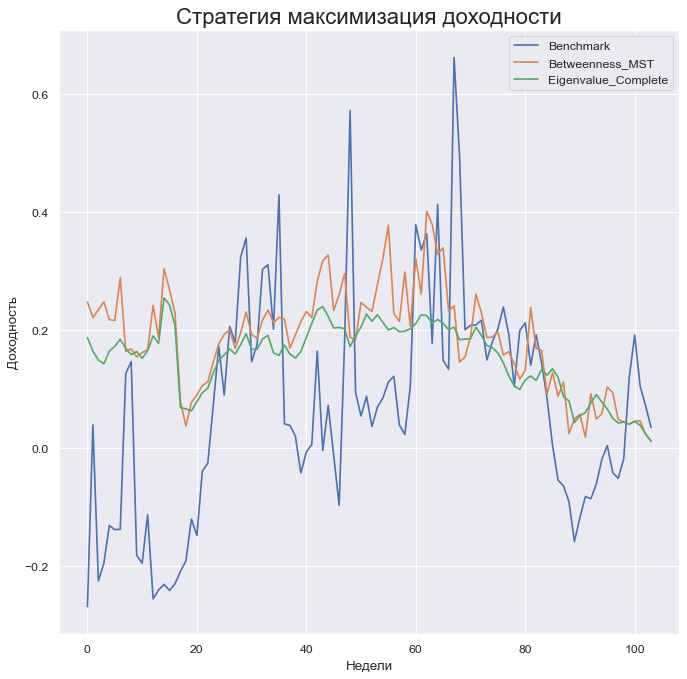

In [202]:
r = pd.DataFrame(MAX_returns['Benchmark'], columns=["Доходность"])
r = r.rename_axis('Недели').reset_index()

figure(figsize=(10, 10), dpi=80)
sns.lineplot(data=r, label  = 'Benchmark', legend = 'full', x = 'Недели' , y  = 'Доходность')
sns.lineplot(data=MAX_returns['Betweenness_MST'], label  = 'Betweenness_MST', legend = 'full')
sns.lineplot(data=MAX_returns['Eigenvalue_Complete'], label = 'Eigenvalue_Complete', legend = 'full').set_title('Стратегия максимизация доходности', size = 20)


Text(0.5, 1.0, 'Стратегия минимизации риска')

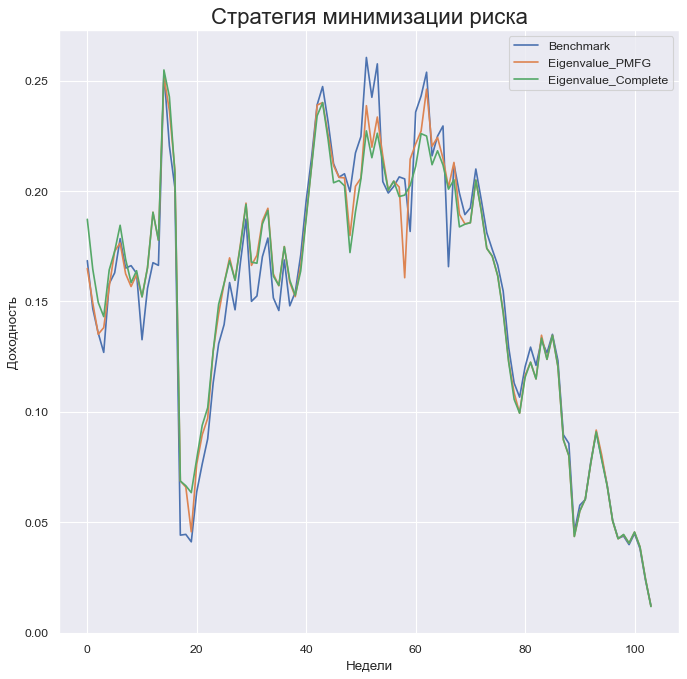

In [203]:
r = pd.DataFrame(MIN_returns['Benchmark'], columns=["Доходность"])
r = r.rename_axis('Недели').reset_index()

figure(figsize=(10, 10), dpi=80)
sns.lineplot(data=r, label  = 'Benchmark', legend = 'full', x = 'Недели' , y  = 'Доходность')
sns.lineplot(data=MIN_returns['Eigenvalue_PMFG'], label  = 'Eigenvalue_PMFG', legend = 'full')
sns.lineplot(data=MIN_returns['Eigenvalue_Complete'], label = 'Eigenvalue_Complete', legend = 'full').set_title('Стратегия минимизации риска', size = 20)
